In [1]:
import os

os.chdir("../")

In [2]:
import torch
import triton
from kernel.GEMM import matmul

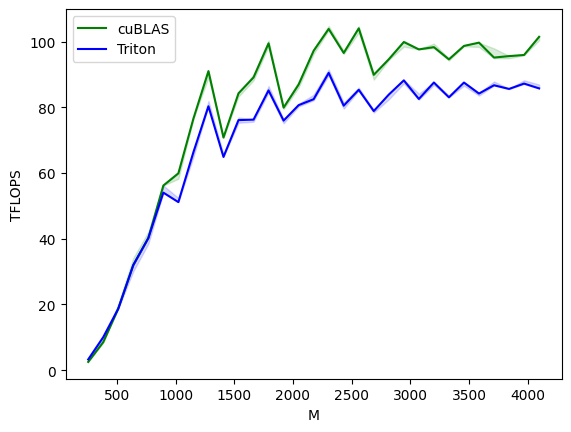

matmul-performance:
         M       N       K      cuBLAS     Triton
0    256.0   256.0   256.0    2.520615   3.276800
1    384.0   384.0   384.0    8.507077  10.053818
2    512.0   512.0   512.0   18.724571  18.724571
3    640.0   640.0   640.0   32.000000  32.000000
4    768.0   768.0   768.0   40.215272  40.215272
5    896.0   896.0   896.0   56.197121  54.035693
6   1024.0  1024.0  1024.0   59.918627  51.150050
7   1152.0  1152.0  1152.0   76.563695  66.355199
8   1280.0  1280.0  1280.0   91.022221  80.313727
9   1408.0  1408.0  1408.0   70.802289  64.902096
10  1536.0  1536.0  1536.0   84.260572  76.106321
11  1664.0  1664.0  1664.0   89.098141  76.261964
12  1792.0  1792.0  1792.0   99.463928  85.147151
13  1920.0  1920.0  1920.0   79.907518  75.956043
14  2048.0  2048.0  2048.0   86.928580  80.659693
15  2176.0  2176.0  2176.0   97.215689  82.473969
16  2304.0  2304.0  2304.0  103.860311  90.484363
17  2432.0  2432.0  2432.0   96.544549  80.499895
18  2560.0  2560.0  2560.0  10

In [4]:
ref_lib = 'cuBLAS'
configs = []
torch.backends.cuda.matmul.allow_tf32 = True
configs.append(
    triton.testing.Benchmark(
        x_names=["M", "N", "K"],  # Argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 33)],  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        # Don't compare to cublas for fp8 cases as torch.matmul doesn't support fp8 at the moment.
        line_vals=[ref_lib.lower(), "triton"],  # Label name for the lines
        line_names=[ref_lib, "Triton"],  # Line styles
        styles=[("green", "-"), ("blue", "-")],  # Line colors and styles
        ylabel="TFLOPS",  # Label name for the y-axis
        plot_name="matmul-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    ))


@triton.testing.perf_report(configs)
def benchmark(M, N, K, provider):
    a = torch.randn((M, K), device='cuda', dtype=torch.float32)
    b = torch.randn((K, N), device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == ref_lib.lower():
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a, b), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul(a, b, tf32=torch.backends.cuda.matmul.allow_tf32), quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

benchmark.run(show_plots=True, print_data=True)